
# Credit Card Fraud Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Fraudulent Transactions**_

### All the code is on this github repo: https://github.com/wmlba/Fraud_Detection_Techniques

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)

---

## Background



Identifying Credit Card Fraudulent transaction is crucial to the banking business to protect their customers from fraud. Identifying fraud transactions is not an easy task and it can consume a lot of auditors time to identify those transactions and it can delay the purchasing of whatever items the card holder wants to purchase.

In this notebook, I will demonstrate how to build an binary classification model to predict whether a specific credit card transaction is genuine of fraud. I will use Sagemaker's implementation of XGBoost algorithm.




---
## Machine Learning Process

<img src="./images/MLProcess.png">





## Decision Trees and XGBoost

<img src="./images/decision_trees2.png" width="700" height="700">
<img src="./images/decision_trees.png" width="700" height="700">


**Source:** https://xgboost.readthedocs.io/en/latest/tutorials/model.html


### Why XGBoost? 



In [2]:
!pip install boto3

In [3]:
!pip install sagemaker

  Created wheel for sagemaker: filename=sagemaker-1.51.3-py2.py3-none-any.whl size=395948 sha256=be28f6274b6dd2523567d53c0f018e7474f70f2711f56427a5dfb2fa1a658b56
  Stored in directory: c:\users\tam tran\appdata\local\pip\cache\wheels\6d\6f\46\75cae5b1526221ff3a90d16e7ddf51565f63796d40b73db760
  Created wheel for protobuf3-to-dict: filename=protobuf3_to_dict-0.1.5-py3-none-any.whl size=4033 sha256=01289a4b3cd36929d50bedccbfb2f0a6cf3a9a484d56ded1292e00b6ff051df5
  Stored in directory: c:\users\tam tran\appdata\local\pip\cache\wheels\ce\a0\8b\995ce2fbaf0e9fe7eb91da84e99e84d1b35cfaa555f2b8f1c7
Successfully built sagemaker protobuf3-to-dict
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 0.23
    Uninstalling importlib-metadata-0.23:
      Successfully uninstalled importlib-metadata-0.23
  Attempting uninstall: packaging
    Found existing installation: packaging 19.2
    Uninstalling packaging-19.2:
      Successfully uninstalled packaging-19.

In [1]:
# Define IAM role
import boto3
import re
import sagemaker
import seaborn as sns

#role = sagemaker.get_execution_role()

#Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
#manipulating entities and resources that Amazon SageMaker uses, such as training jobs, endpoints, and input datasets in S3.
#sess = sagemaker.Session()
#bucket = sess.default_bucket()
#prefix = 'DEMO-xgboost-fraud-detection'


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', 500)

## Install pre-requisite libraries

In [6]:
!pip install imblearn graphviz xgboost

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.6.2-py3-none-any.whl (163 kB)


---
## Data


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset we use is publicly available at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [3]:
#!unzip -o ./data/creditcardfraud.zip -d ./data
credit_df = pd.read_csv('creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


# Exploratory Data Analysis

<img src="./images/MLProcess2.png" width="200" height="200">

### 1- Get The Dataframe Summary

Looks like the ```Time``` and ```Amount``` features need scaling

In [4]:
# Summarize the credit_df dataframe after scaling
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### Check data profiling

In [11]:
#!pip install pandas-profiling

In [12]:
# Display the application train dataframe's profile report in a HTML file 
import pandas_profiling
credit_df_profile = pandas_profiling.ProfileReport(credit_df)

C:\Users\Tam Tran\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


### 2- Checking The Balance of The Data

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [5]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')


The number of Non-Frauds are: 284315 which is  99.83 % of the dataset
The number of Frauds are: 492 which is  0.17 % of the dataset


#### Plot the Class Distribution

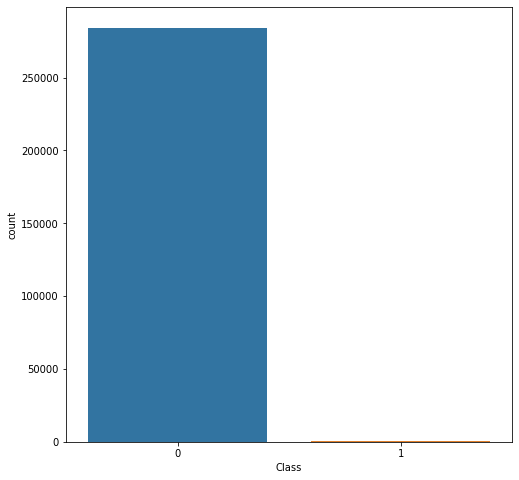

In [6]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=credit_df)

### 3- Checking Missing Data

If there are any missing data in our dataset, we need to deal with them before training. Data Imputation is a critical step in the Feature Engineering phase.

In [7]:
credit_df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt

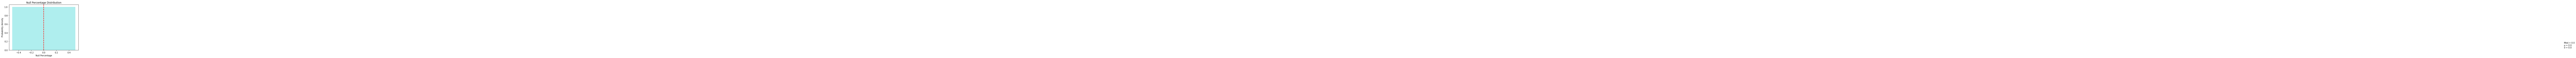

In [9]:
# Check null percentage of all table's columns
null_credit_df = [float('{:,.2f}'.format(credit_df[col].isnull().sum() / credit_df.shape[0] * 100)) for col in credit_df.columns]
df_null_credit_df = pd.DataFrame(data={'Column Name': credit_df.columns,'Null Percentage': null_credit_df})

# Plot null percentage distribution
import matplotlib.pyplot as plt

list_null_credit_df = list(df_null_credit_df['Null Percentage'])

mean_credit_df = np.round(np.mean(list_null_credit_df),2)
median_credit_df = np.round(np.median(list_null_credit_df),2)
sigma_credit_df = np.round(np.std(list_null_credit_df),2)

plt.hist(list_null_credit_df, bins='auto', density=True, color='paleturquoise')
plt.axvline(mean_credit_df, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(median_credit_df, color='red', linestyle='dashed', linewidth=2)

plt.title('Null Percentage Distribution')
plt.xlabel('Null Percentage')
plt.ylabel('Probability density')
plt.text(40, 0.04, 'Med = ' + str(median_credit_df) + u'\n\u03BC = ' + str(mean_credit_df) + u'\n\u03C3 = ' + str(sigma_credit_df))

plt.show()

In [10]:
# Number of total columns
print('Number of Total Columns: ', len(credit_df.columns))

# Count number of unique values for each table's column
credit_df_unique_count = pd.DataFrame({'Count Unique Value': credit_df.T.apply(lambda x: x.nunique(), axis=1)})

# List columns with unique values
print('\nColumns with Unique Values: ', list(credit_df_unique_count.index[credit_df_unique_count['Count Unique Value']==credit_df.shape[0]]))
print('\nData Sample of Columns with Unique Values: ')
print(credit_df[credit_df_unique_count.index[credit_df_unique_count['Count Unique Value']==credit_df.shape[0]]].iloc[0])

# List columns with one value
print('\nColumns with One Value: ', list(credit_df_unique_count.index[credit_df_unique_count['Count Unique Value']==1]))
print('\nData Sample of Columns with One Value: ')
print(credit_df[credit_df_unique_count.index[credit_df_unique_count['Count Unique Value']==1]].iloc[0])

# Number of columns with non-unique values
credit_df_nonunique_col = credit_df_unique_count.index[(credit_df_unique_count['Count Unique Value']>1) & (credit_df_unique_count['Count Unique Value']<credit_df.shape[0])]
print('\nColumns with Non-unique Values:', len(credit_df_nonunique_col))

Number of Total Columns:  31

Columns with Unique Values:  []

Data Sample of Columns with Unique Values: 
Series([], Name: 0, dtype: float64)

Columns with One Value:  []

Data Sample of Columns with One Value: 
Series([], Name: 0, dtype: float64)

Columns with Non-unique Values: 31


### 3- Feature Correlation

A correlation matrix is a way to show the correlation between different variables in a dataset. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data and find what , as an input into a more advanced analysis

**Positive Correlation means:** As feature X increases, feature Y increases and vice versa.

**Negative Correlation means:** As feature X go in one direction (Increase), feature Y goes in the other direction (Decrease)

Let's plot the first correlation matrix for the imbalanced data.

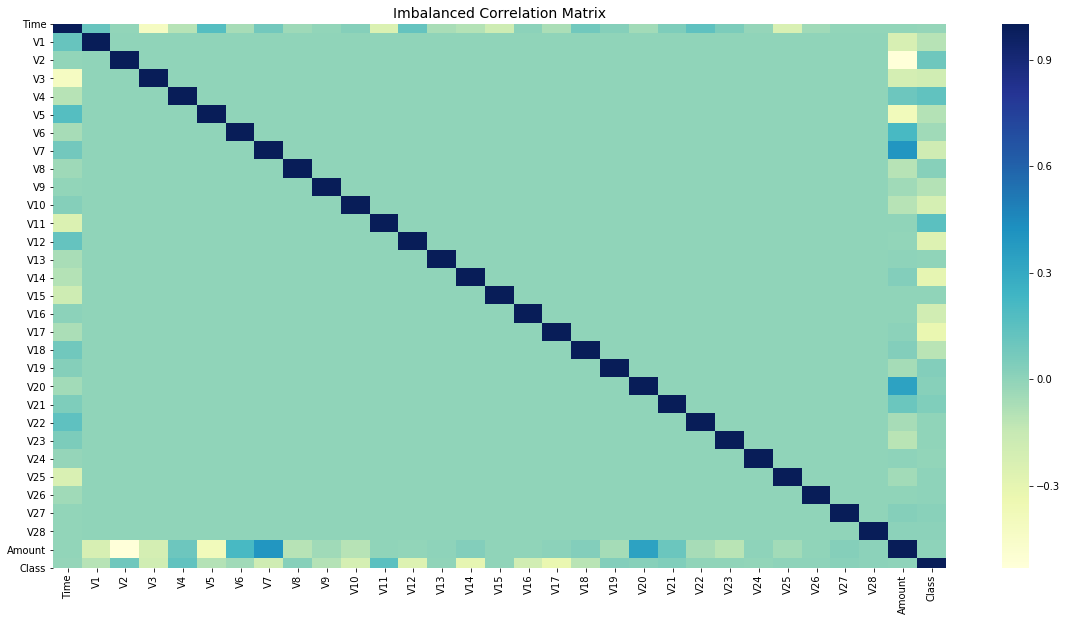

In [11]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = credit_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Feature Engineering

1- Scale the features that needs scaling.

2- Fix the target feature imbalance problem.

3- Detect and Remove Outliers.

3- Split the data to train, validation and test.

<img src="./images/fengineering.png" width="200" height="200">

### 1- Fixing The Feature Scaling Problem For (Time and Amount)

In [12]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is robust to outliers.

credit_df['amount_after_scaling'] = RobustScaler().fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['time_after_scaling'] = RobustScaler().fit_transform(credit_df['Time'].values.reshape(-1,1))

credit_df.drop(['Time','Amount'], axis=1, inplace=True)

# Place the class in the begining of the dataframe
Class = credit_df['Class']
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', Class)

In [13]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.001727,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.927124,0.118914
std,0.041527,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,3.495006,0.557903
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-0.307413,-0.994983
25%,0.000000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,-0.229162,-0.358210
50%,0.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,0.000000,0.000000
75%,0.000000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,0.770838,0.641790
max,1.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,358.683155,1.035022


We can see immediately that:
- `time_after_scaling` appears to be quite evenly distributed and scaled with min and max values are within the range of the other features
- `amount_after_scaling` transaction amount values are also scaled to be within the range of the other features with min of -0.307 and max of 358.68

### 2- Fix the target feature imbalance problem (Resampling)

<img src="./images/resampling.png">

#### Undersampling The Class Feature

In [14]:
# Shuffle the Dataset.
shuffled_df = credit_df.sample(frac=1,random_state=4)

# amount of fraud classes 492 rows.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 492 observations.
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492,random_state=42)
normalized_df = pd.concat([fraud_df, non_fraud_df])

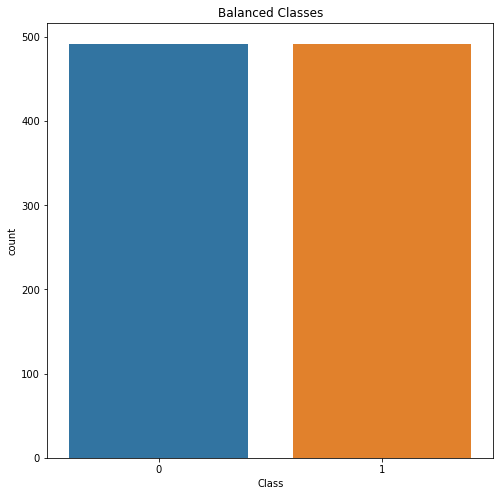

In [15]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#### Oversampling The Class Feature

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_sample(credit_df.drop('Class', axis=1), credit_df['Class'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = normalized_df.columns

In [18]:
normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
9179,1,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734442,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,-0.293440,-0.840776
223618,1,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,-4.400930,4.213213,-5.737815,-0.875693,-8.893726,-0.562434,-3.281784,-4.368986,-0.736734,1.609293,0.474414,0.713907,-0.063868,0.167947,-0.449864,0.023702,0.536905,0.485864,-0.042393,-0.293440,0.690375
9487,1,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,-0.293440,-0.829650
10497,1,1.189784,0.942289,0.082334,3.024050,0.412406,-0.214415,0.053558,-0.110353,0.883798,-0.554224,0.154921,-2.776757,1.641207,-0.456077,-1.240414,0.857323,1.707024,0.526349,-0.865105,-0.143435,-0.502636,-1.047398,-0.056752,-0.340688,0.541235,-0.098300,-0.003041,0.049819,-0.254454,-0.792678
250761,1,-0.512349,4.827060,-7.973939,7.334059,0.367704,-2.055129,-2.935856,1.431008,-4.544722,-5.258096,5.716319,-5.810407,0.723293,-12.289133,0.378773,-2.020734,-2.039703,0.658183,0.832574,0.804101,0.535620,-0.459496,-0.009364,-1.140436,-0.006445,0.527970,0.558881,0.126517,-0.296653,0.826631


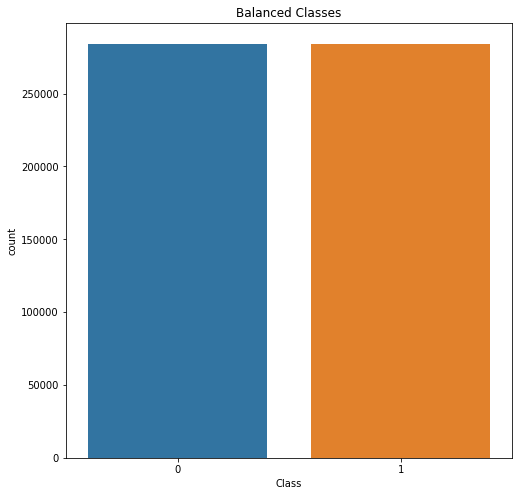

In [19]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=oversampled_train)
plt.title('Balanced Classes')
plt.show()

### Check The Correlation Matrix After Downsampling

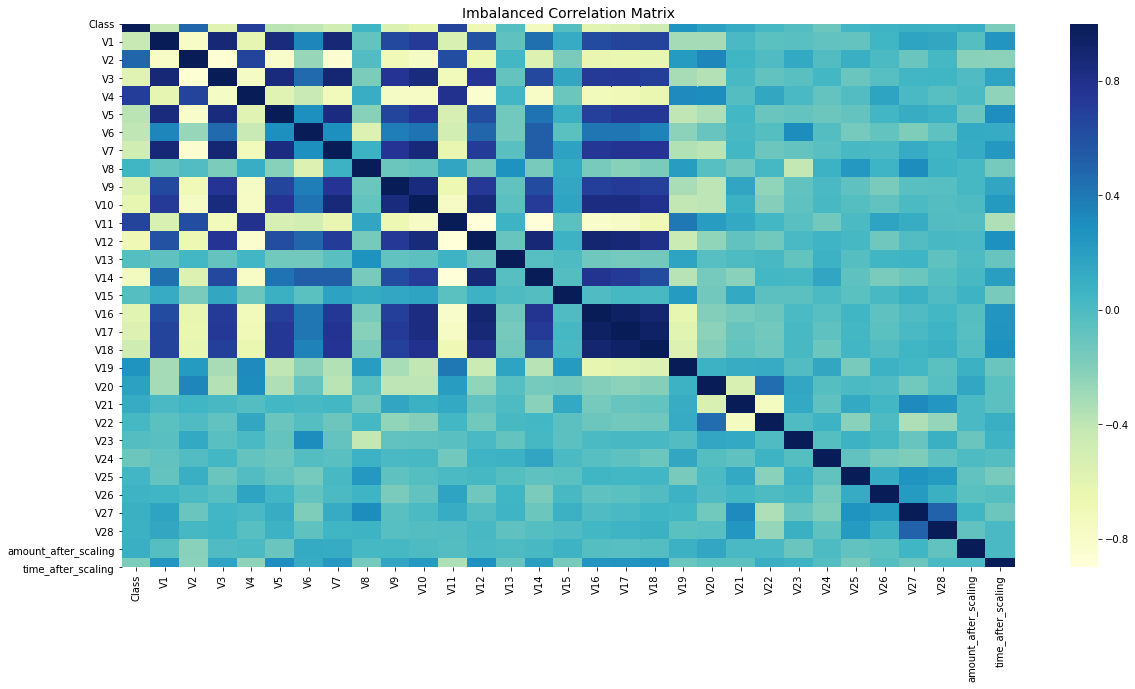

In [20]:
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = normalized_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

**Negative Correlations:** Some features, such as V17, V14, V12 are negatively correlated with the target class. That means that the lower these values, the more likely the transaction will be a fraudulent.

**Positive Correlations:** Features V2, V4, V11 are positively correlated. That means that the higher these values, the more likely the transaction will be a fraudulent.

Now, let's find any outliers in those features:

--------------------



### Boxplot (Detecting Outliers)

<img src="./images/plotbox.png">

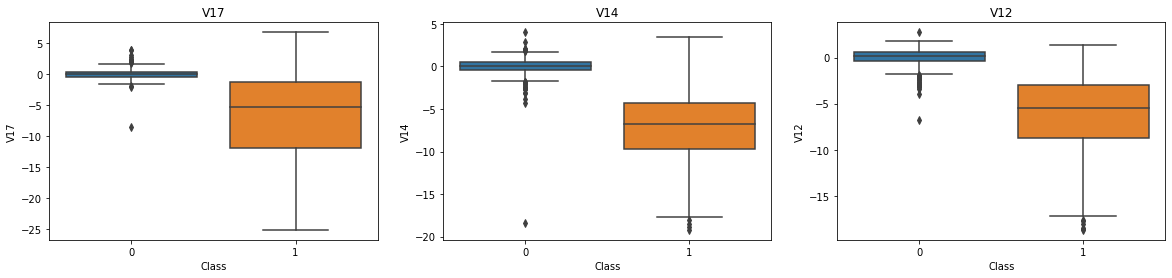

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df, ax=axes[2])
axes[2].set_title('V12')


plt.show()

### 3- Remove Outliers and re-plot the Boxplot

In [22]:
V17_non_fraud = normalized_df.query('V17 > -7 & Class == 0')
V17_fraud = normalized_df.query('Class == 1')
normalized_df_no_outlier = pd.concat([V17_non_fraud,V17_fraud])



#### Check the Boxplot after removing the major outliers.

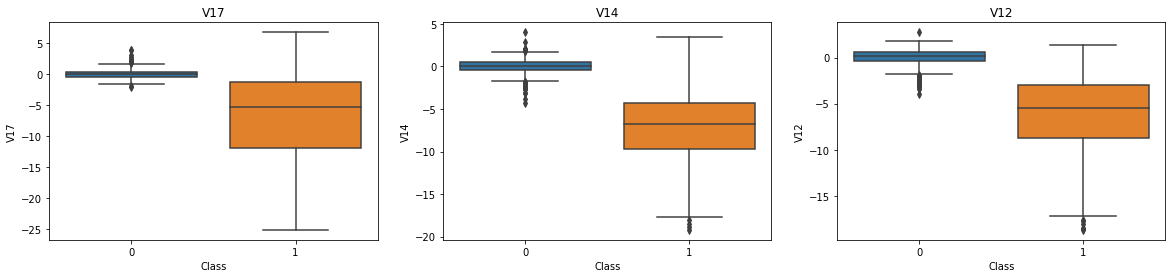

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df_no_outlier, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df_no_outlier, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df_no_outlier, ax=axes[2])
axes[2].set_title('V12')


plt.show()

#### Shuffle the normalized dataset before splitting

In [27]:
shuffled_normalized_df = normalized_df.sample(frac=1)
shuffled_normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
158511,0,2.289978,-1.490262,-2.215196,-2.396732,1.245451,3.478249,-1.721757,0.719130,-0.118316,1.225422,0.728052,-3.229559,1.954363,1.228464,-0.550358,-0.737957,1.167862,-0.014673,-0.461436,-0.407310,-0.320498,-0.259529,0.279906,0.625868,-0.151374,-0.178901,0.001929,-0.064144,-0.097813,0.313338
1335,0,0.896741,-0.630224,0.405024,0.582719,-0.939855,-0.568730,-0.043449,0.025718,0.493937,-0.141766,1.011252,0.477815,-1.591525,0.453185,-0.687165,-0.084879,-0.009937,-0.125556,0.525236,0.112209,-0.100984,-0.556825,-0.081513,0.550401,0.244071,0.461153,-0.081473,0.023914,1.900370,-0.982730
226877,1,-6.423306,1.658515,-5.866440,2.052064,-0.615817,-3.372266,-5.036556,2.643106,-2.274630,-7.049229,3.916803,-4.481280,-1.027479,-7.113873,-0.852775,-3.839560,-5.056010,-1.344498,1.148473,-0.713516,0.641211,-0.256678,-2.337233,-0.158278,1.198797,-0.261258,0.780125,-0.731801,-0.307413,0.706622
123471,0,0.251815,-1.835563,-1.179816,0.312263,-0.094471,0.366651,0.844165,-0.205575,0.263457,-0.495379,-1.515064,-0.035872,0.289183,0.225408,0.523406,-0.106713,-0.161692,-0.637156,0.285020,1.083616,0.193995,-0.547808,-0.732670,-1.193197,0.452937,1.145405,-0.186900,0.074900,7.728638,-0.091096
229712,1,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,-4.063098,2.941190,-6.151362,-1.989529,-9.150951,-0.604290,-1.952290,-2.892555,-0.912058,-1.563740,0.241921,0.407260,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,-0.290924,0.720521


### 4- Split the train/test data (Used For Evaluation Step)

In [25]:
train_data, validation_data, test_data = np.split(shuffled_normalized_df, [int(0.7 * len(shuffled_normalized_df)), int(0.9 * len(shuffled_normalized_df))])
train_data.to_csv('./data/train.csv', header=False, index=False)
validation_data.to_csv('./data/validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [26]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('./data/train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('./data/validation.csv')

NameError: name 'bucket' is not defined

## Next Steps

At this point you have uploaded the data successfully the default S3 bucket. Now it is time to get started in the next notebook to build your first model. To Continue, execute the cell below to store important variables where they can be used in the next notebook, then open **02_Training and Tuning.ipynb**

In [ ]:
%store train_data 
%store validation_data 
%store test_data
%store shuffled_normalized_df